<a href="https://colab.research.google.com/github/wkba/kaggle/blob/main/titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install kaggle
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

# Google Colaboratory上からGoogle Drive上のファイルにアクセスできるようにする
from google.colab import drive
drive.mount('/content/drive')

# ~/.kaggleディレクトリを作成し、ここへDrive上のkaggle.jsonをコピーしてくる
!mkdir ~/.kaggle
!cp /content/drive/MyDrive/kaggle/kaggle.json ~/.kaggle/

# アクセス権限の設定
!chmod 600 ~/.kaggle/kaggle.json

#データダウンロード
!kaggle competitions download -c titanic -p /content/drive/MyDrive/kaggle/tmp_data/titanic

#処理
# import pandas as pd

#サブミット
#!kaggle competitions submit -c titanic -f "/content/drive/MyDrive/tmp_data/santander-product-recommendation/gender_submission.csv" -m "Message"

Not connected to a GPU
Mounted at /content/drive
test.csv: Skipping, found more recently modified local copy (use --force to force download)
train.csv: Skipping, found more recently modified local copy (use --force to force download)
gender_submission.csv: Skipping, found more recently modified local copy (use --force to force download)


In [2]:
import pandas as pd
import numpy as np

In [3]:
train_df = pd.read_csv("/content/drive/MyDrive/kaggle/tmp_data/titanic/train.csv")
test_df = pd.read_csv("/content/drive/MyDrive/kaggle/tmp_data/titanic/test.csv")
submission = pd.read_csv("/content/drive/MyDrive/kaggle/tmp_data/titanic/gender_submission.csv")

ランダムシードを設定する

In [4]:
import random
np.random.seed(1234)
random.seed(1234)

In [5]:
print(train_df.shape)
print(test_df.shape)

(891, 12)
(418, 11)


質的変数、量的変数を意識

In [6]:
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


カテゴリ変数を確認する

In [7]:
train_df["Sex"].value_counts()

male      577
female    314
Name: Sex, dtype: int64

In [8]:
train_df["Cabin"].value_counts()

B96 B98        4
C23 C25 C27    4
G6             4
C22 C26        3
F2             3
              ..
D56            1
A32            1
E50            1
C118           1
C87            1
Name: Cabin, Length: 147, dtype: int64

欠損を確認する


In [9]:
train_df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [10]:
test_df.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

データを可視化する

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [12]:
plt.style.use("ggplot")


目的変数について可視化する

In [13]:
train_df[["Embarked","Survived","PassengerId"]]

,Embarked,Survived,PassengerId
0,S,0,1
1,C,1,2
2,S,1,3
3,S,1,4
4,S,0,5
...,...,...,...
886,S,0,887
887,S,1,888
888,S,0,889
889,C,1,890


In [14]:
# 欠損値を含む行を削除する
train_df[["Embarked","Survived","PassengerId"]].dropna()

,Embarked,Survived,PassengerId
0,S,0,1
1,C,1,2
2,S,1,3
3,S,1,4
4,S,0,5
...,...,...,...
886,S,0,887
887,S,1,888
888,S,0,889
889,C,1,890


In [15]:
train_df[["Embarked","Survived","PassengerId"]].dropna().groupby(["Embarked", "Survived"]).count()

PassengerId
Embarked Survived             
C        0                  75
         1                  93
Q        0                  47
         1                  30
S        0                 427
         1                 217

In [16]:
# 横持ちに変換する
embarked_df = train_df[["Embarked","Survived","PassengerId"]].dropna().groupby(["Embarked", "Survived"]).count().unstack()
embarked_df

PassengerId     
Survived           0    1
Embarked                 
C                 75   93
Q                 47   30
S                427  217

積み上げ棒グラフで可視化する

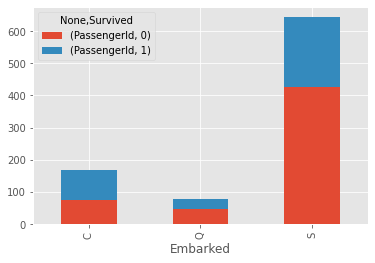

In [17]:
embarked_df.plot.bar(stacked=True)

数値で確認する

In [18]:
embarked_df["survived_rate"] = embarked_df.iloc[:, 0] / (embarked_df.iloc[:, 0] + embarked_df.iloc[:, 1])

In [19]:
embarked_df

PassengerId      survived_rate
Survived           0    1              
Embarked                               
C                 75   93      0.446429
Q                 47   30      0.610390
S                427  217      0.663043

性別やチケット、階級で可視化する

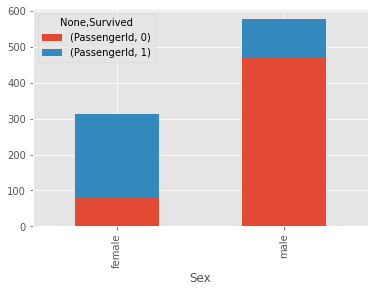

In [20]:
sex_df = train_df[["Sex", "Survived", "PassengerId"]].dropna().groupby(["Sex", "Survived"]).count().unstack()
sex_df.plot.bar(stacked=True)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


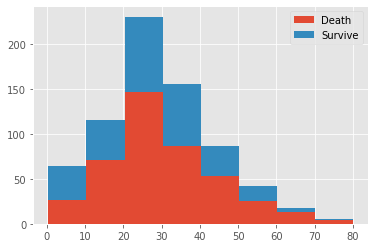

In [27]:
plt.hist(
    (train_df[train_df["Survived"]== 0][["Age"]].values, train_df[train_df["Survived"]==1][["Age"]].values),
    histtype="barstacked", #積み上げヒストグラム
    bins=8, #ビンの数
    label=("Death", "Survive") #ラベル名
    )
plt.legend()

カテゴリ変数をダミー変数化する

In [29]:
train_df_corr = pd.get_dummies(train_df, columns=["Sex"], drop_first=True)
train_df_corr = pd.get_dummies(train_df_corr, columns=["Embarked"])

In [30]:
train_df_corr

,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,1,0,3,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,NaN,1,0,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,C85,0,1,0,0
2,3,1,3,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,NaN,0,0,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,C123,0,0,0,1
4,5,0,3,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,NaN,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",27.0,0,0,211536,13.0000,NaN,1,0,0,1
887,888,1,1,"Graham, Miss. Margaret Edith",19.0,0,0,112053,30.0000,B42,0,0,0,1
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",NaN,1,2,W./C. 6607,23.4500,NaN,0,0,0,1
889,890,1,1,"Behr, Mr. Karl Howell",26.0,0,0,111369,30.0000,C148,1,1,0,0


相関行列を作成する